<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

Aim: Preprocess mouse brain single-cell data from Winkler 2022 Science (human adult brain - healthy controls only)  
Publication: https://pubmed.ncbi.nlm.nih.gov/35084939/

In [1]:
from datetime import date
date.today().strftime('%d/%m/%Y')

'06/03/2025'

In [2]:
import os
os.getlogin()

'simonf'

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from datetime import date
from matplotlib.pyplot import rc_context

In [4]:
import utils

In [5]:
os.environ['CONDA_DEFAULT_ENV'] # conda env

'scanpy'

In [6]:
platform.platform()

'macOS-15.3.1-arm64-arm-64bit'

In [7]:
sc.settings.verbosity = 3

In [9]:
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win

In [10]:
main_dir='/Volumes/BD-Dichgans/SF' # Mac

In [11]:
dataset_name = "Winkler2022"
organism = "Human"

# Load data

## Annotated 
Downloaded from: https://cells.ucsc.edu/?bp=brain&dis=Healthy~Healthy+Control&org=Human+(H.+sapiens)&ds=adult-brain-vasc

### EC dataset

In [12]:
ad = sc.read_text(os.path.join(main_dir, "P06_vasc_scRNAseq", "Winkler2022", "ucsc_cellbrowser_data", "EC", "exprMatrix.tsv.gz")).transpose()
original_cellnames = ad.obs

In [13]:
meta = pd.read_csv(os.path.join(main_dir, "P06_vasc_scRNAseq", "Winkler2022", "ucsc_cellbrowser_data", "EC", "meta.tsv"), sep="\t")
ad.obs = meta
ad

AnnData object with n_obs × n_vars = 5018 × 29492
    obs: 'Cell', 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'doublet2', 'doublet3', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'clusters', 'Art_UCell', 'Cap_UCell', 'Venous_UCell', 'Venule_UCell', 'Cluster'

In [14]:
ad.obs.columns

Index(['Cell', 'orig.ident', 'nCount_spliced', 'nFeature_spliced',
       'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined',
       'nFeature_combined', 'percent.mt', 'doublet2', 'doublet3', 'softmax',
       'nCount_SCT', 'nFeature_SCT', 'clusters', 'Art_UCell', 'Cap_UCell',
       'Venous_UCell', 'Venule_UCell', 'Cluster'],
      dtype='object')

In [15]:
ad.obs.head(2)

,Cell,orig.ident,nCount_spliced,nFeature_spliced,nCount_unspliced,nFeature_unspliced,Sample,nCount_combined,nFeature_combined,percent.mt,...,doublet3,softmax,nCount_SCT,nFeature_SCT,clusters,Art_UCell,Cap_UCell,Venous_UCell,Venule_UCell,Cluster
0,GGTGTCGTCAACTGAC_9,ctrl085_L,38258.9096,5725,23647.0904,5208,CTRL085,61906.0,8533,8.001521,...,Singlet,0.022721,5530,2441,Venous,0.348467,0.291344,0.824233,0.095844,Venous
1,TCATTCAAGACGCTCC_9,ctrl085_L,43172.4200,6623,25432.5800,5587,CTRL085,68605.0,9549,8.604769,...,Singlet,0.006188,5127,2498,Art1,0.701656,0.210244,0.223356,0.061833,Art1


In [16]:
assert(all(ad.obs["Cell"] == original_cellnames.index))

In [17]:
ad.obs["Sample"].unique()

array(['CTRL085', 'CTRL086', 'CTRL099_21', 'CTRL099_22', 'CTRL12'],
      dtype=object)

In [18]:
# add umap coords
umap = pd.read_csv(os.path.join(main_dir, "P06_vasc_scRNAseq", "Winkler2022", "ucsc_cellbrowser_data", "EC", "Seurat_umap.coords.tsv.gz"), sep="\t", header=None)
ad.obsm['X_umap'] = umap[[1,2]].to_numpy()

In [19]:
ad = ad[(ad.obs.doublet2 != 'Doublet') & (ad.obs.doublet3 != 'Doublet')] # remove doublets

In [20]:
del ad.obs['clusters']

In [21]:
ad.obs['Cluster']

0       Venous
1         Art1
2       Venous
3       Venous
4       Venous
         ...  
5013       Cap
5014    Venule
5015      Art2
5016    Venule
5017       Cap
Name: Cluster, Length: 4950, dtype: object

In [22]:
ad.obs["clusters2"] = 'ECs_' + ad.obs['Cluster'].astype(str)

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_12140/950043674.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs["clusters2"] = 'ECs_' + ad.obs['Cluster'].astype(str)
/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [23]:
ad.obs["clusters2"] = 'ECs_' + ad.obs['Cluster'].astype(str)

In [24]:
ad.obs['clusters2'].unique()

array(['ECs_Venous', 'ECs_Art1', 'ECs_Art3', 'ECs_Cap', 'ECs_Art2',
       'ECs_Venule'], dtype=object)

In [25]:
# merge subclusters
new_names = {
    'ECs_Arterial': {'ECs_Art1','ECs_Art2','ECs_Art3'},
    'ECs_Capillary': {'ECs_Cap'},
    'ECs_Venous': {'ECs_Venous','ECs_Venule'},
    'Pericytes': {'PC'},
    'SMCs': {'aSMC','aaSMC','vSMC'},
    'Oligos': {'OL'},
    'Fibroblasts': {'FB1', 'FB2'},
    'Microglia': {'MG'},
    'Astrocytes': {'AC'}
}
# re-format
result = {}
for key, value in new_names.items():
    for elem in value:
        result[(elem)] = key
new_cluster_names = dict(sorted(result.items()))
print(new_cluster_names)

{'AC': 'Astrocytes', 'ECs_Art1': 'ECs_Arterial', 'ECs_Art2': 'ECs_Arterial', 'ECs_Art3': 'ECs_Arterial', 'ECs_Cap': 'ECs_Capillary', 'ECs_Venous': 'ECs_Venous', 'ECs_Venule': 'ECs_Venous', 'FB1': 'Fibroblasts', 'FB2': 'Fibroblasts', 'MG': 'Microglia', 'OL': 'Oligos', 'PC': 'Pericytes', 'aSMC': 'SMCs', 'aaSMC': 'SMCs', 'vSMC': 'SMCs'}


In [26]:
# fine annotation
ad.obs['clusters2'] = (
    ad.obs['clusters2']
    .map(new_cluster_names)
    .astype('category')
)

In [27]:
ad.obs['clusters2'].unique()

['ECs_Venous', 'ECs_Arterial', 'ECs_Capillary']
Categories (3, object): ['ECs_Arterial', 'ECs_Capillary', 'ECs_Venous']

In [28]:
ad.obs['clusters'] = "ECs"

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


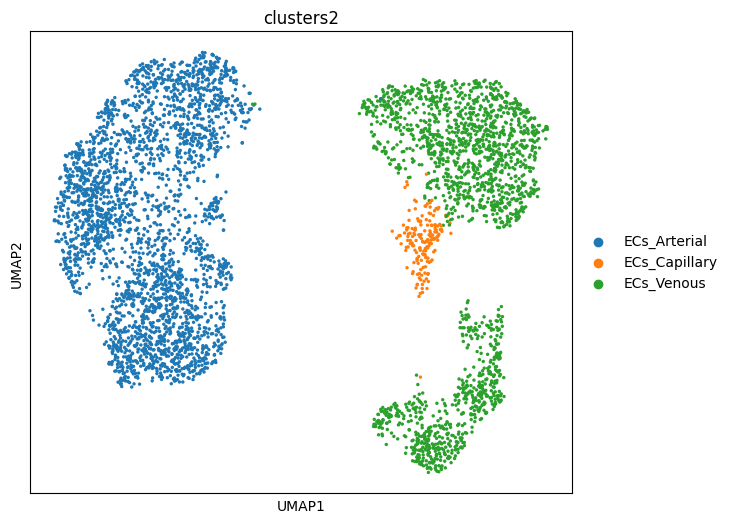

In [29]:
with rc_context({'figure.figsize': (7, 6)}):
    sc.pl.umap(ad, color=['clusters2'])

Check if data is normalized:

In [30]:
ad.layers

Layers with keys: 

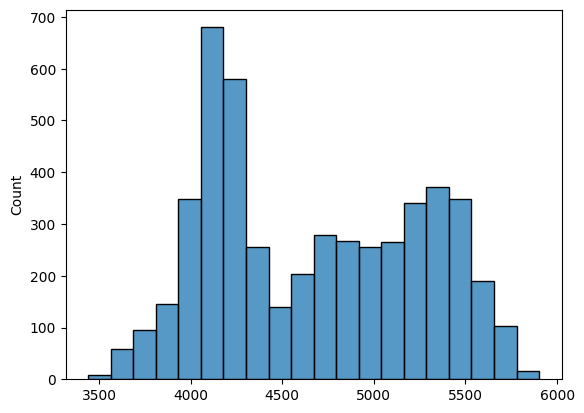

In [31]:
sns.histplot(ad.X.sum(1))
plt.show()

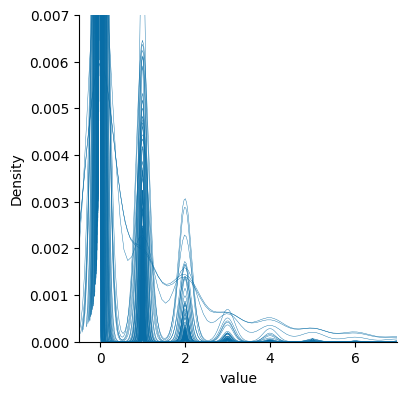

In [32]:
# show expression of 100 random genes (across all spots)
import random
random_genes=random.sample(range(0, ad.X.shape[1]), 100)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
plt.show()

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_12140/3027945264.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


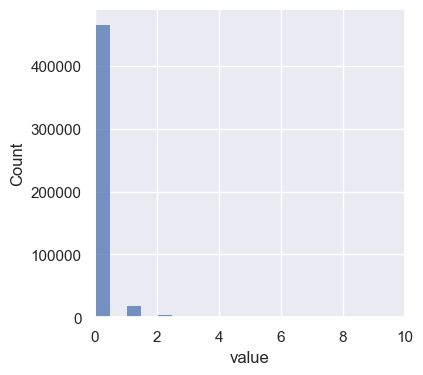

In [33]:
sns.set(rc={'figure.figsize':(4,4)})
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10));
sns.set_style("ticks")
plt.show()

Data is not normalized, therefore normalize and log-transform

In [34]:
ad.layers["counts"] = ad.X.copy() # save unnormalized raw RNA counts - retrieve via ad.X = ad.layers["counts"]

In [35]:
sc.pp.normalize_total(ad, inplace=True) # Normalize each spot by total counts over all genes, so that every spot has the same total count after normalization.

normalizing counts per cell
    finished (0:00:00)


In [36]:
sc.pp.log1p(ad) # X = log(X + 1)

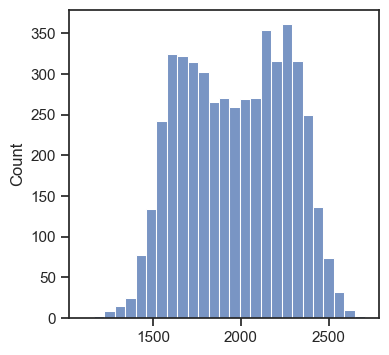

In [37]:
sns.histplot(ad.X.sum(1))
plt.show()

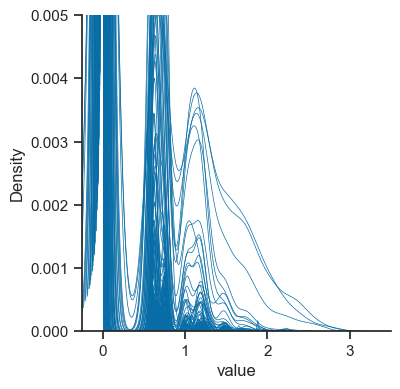

In [38]:
# show expression of 100 random genes (across all spots)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.5) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005));
plt.show()

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_12140/2170774648.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));


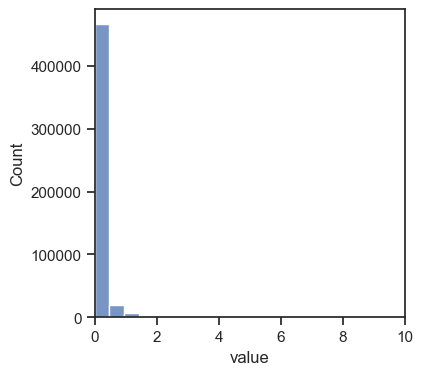

In [39]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));
pl.set(xlim=(0, 10));
plt.show()

In [40]:
ad.layers["normalized"] = ad.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


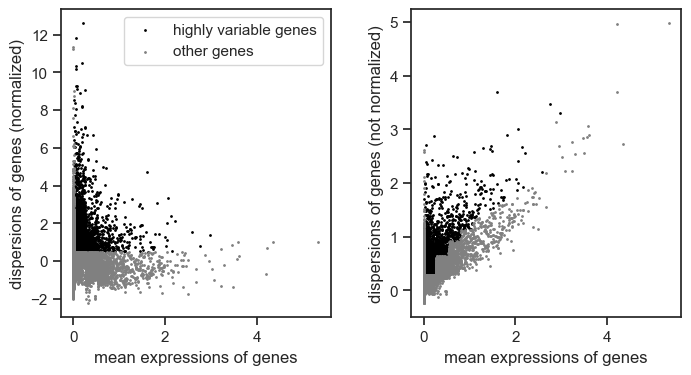

In [41]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(ad)
sc.pl.highly_variable_genes(ad)

In [42]:
ad

AnnData object with n_obs × n_vars = 4950 × 29492
    obs: 'Cell', 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'doublet2', 'doublet3', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'Art_UCell', 'Cap_UCell', 'Venous_UCell', 'Venule_UCell', 'Cluster', 'clusters2', 'clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters2_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'normalized'

In [43]:
ad.layers

Layers with keys: counts, normalized

In [44]:
winkler_ec = ad

In [45]:
del ad

### Perivascular dataset

In [46]:
ad = sc.read_text(os.path.join(main_dir, "P06_vasc_scRNAseq", "Winkler2022", "ucsc_cellbrowser_data", "Perivascular", "exprMatrix.tsv.gz")).transpose()
original_cellnames = ad.obs

In [47]:
meta = pd.read_csv(os.path.join(main_dir, "P06_vasc_scRNAseq", "Winkler2022", "ucsc_cellbrowser_data", "Perivascular", "meta.tsv"), sep="\t")
ad.obs = meta
ad

AnnData object with n_obs × n_vars = 49553 × 36138
    obs: 'cellId', 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'clusters', 'FBMC_score', 'SMC_score', 'FB_score', 'PC_score', 'sub_clusters'

In [48]:
ad.obs.columns

Index(['cellId', 'orig.ident', 'nCount_spliced', 'nFeature_spliced',
       'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined',
       'nFeature_combined', 'percent.mt', 'softmax', 'nCount_SCT',
       'nFeature_SCT', 'clusters', 'FBMC_score', 'SMC_score', 'FB_score',
       'PC_score', 'sub_clusters'],
      dtype='object')

In [49]:
ad.obs.head(2)

,cellId,orig.ident,nCount_spliced,nFeature_spliced,nCount_unspliced,nFeature_unspliced,Sample,nCount_combined,nFeature_combined,percent.mt,softmax,nCount_SCT,nFeature_SCT,clusters,FBMC_score,SMC_score,FB_score,PC_score,sub_clusters
0,GCGTGCACAATCCTTT_9,ctrl085_L,45786.477119,6851,18618.522899,5258,CTRL085,64405.000018,9527,8.891061,0.003459,5009,2365,FBMC,0.853494,-0.115504,0.312556,0.014801,FBMC2
1,TCGGTCTCACATAACC_9,ctrl085_L,58604.482805,7658,22669.517186,5735,CTRL085,81273.999990,10382,8.676364,0.006037,5001,2388,FBMC,1.030248,0.097485,0.466670,0.020408,FBMC2


In [50]:
assert(all(ad.obs["cellId"] == original_cellnames.index))

In [51]:
ad.obs["Sample"].unique()

array(['CTRL085', 'CTRL086', 'CTRL099_21', 'CTRL099_22', 'CTRL12'],
      dtype=object)

In [52]:
# add umap coords
umap = pd.read_csv(os.path.join(main_dir, "P06_vasc_scRNAseq", "Winkler2022", "ucsc_cellbrowser_data", "Perivascular", "UMAP.coords.tsv.gz"), sep="\t", header=None)
ad.obsm['X_umap'] = umap[[1,2]].to_numpy()

In [53]:
# no doublets defined in obs
# ad = ad[(ad.obs.doublet2 != 'Doublet') & (ad.obs.doublet3 != 'Doublet')] # remove doublets

In [54]:
# Renaming
old_to_new = {'FB':'Fibroblasts','FBMC':'Fibromyocytes','PC':'Pericytes','SMC':'SMCs'}
ad.obs['clusters2'] = (
    ad.obs['clusters'].map(old_to_new).astype('category')
)

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


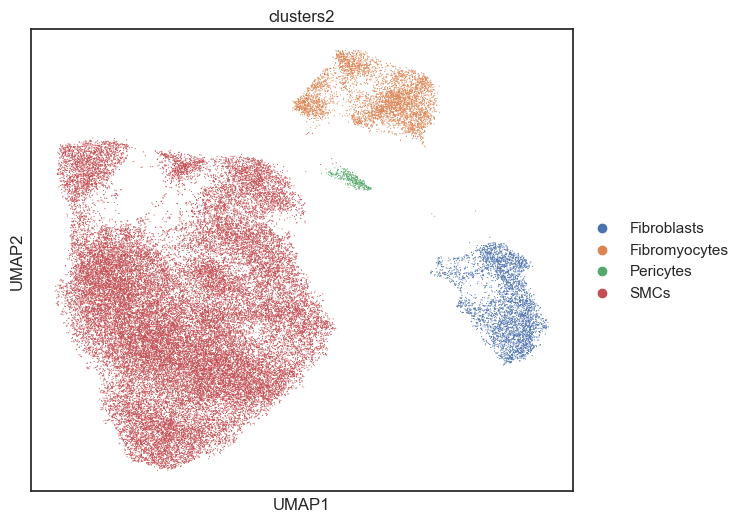

In [55]:
with rc_context({'figure.figsize': (7, 6)}):
    sc.pl.umap(ad, color=['clusters2'])

Check if data is normalized:

In [56]:
ad.layers

Layers with keys: 

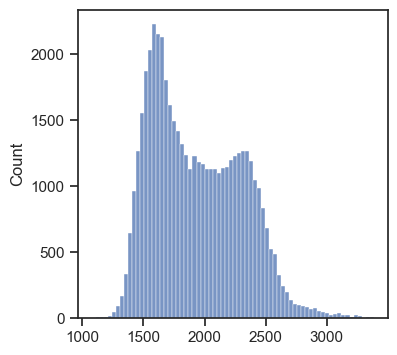

In [57]:
sns.histplot(ad.X.sum(1))
plt.show()

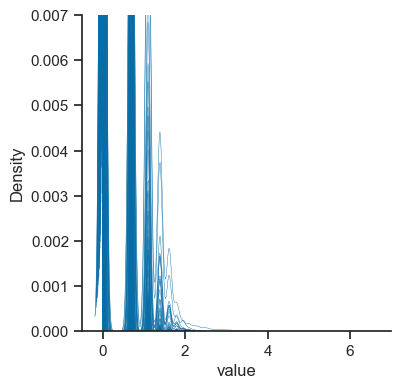

In [58]:
# show expression of 100 random genes (across all spots)
random_genes=random.sample(range(0, ad.X.shape[1]), 100)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
sns.set_style("ticks")
plt.show()

In [59]:
exp.iloc[0:5,0:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.94591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.60944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.79176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.60944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.09861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Note: Matrix is apparently log-transformed. Also see https://github.com/cnk113/vascular-analysis/issues/1.

In [60]:
# reverse log-transformation ln(x+1)
import math
ad.layers["counts"] = (math.e**(ad.X))-1

In [61]:
ad.layers["log?"] = ad.X

In [62]:
ad.X = ad.layers["counts"]

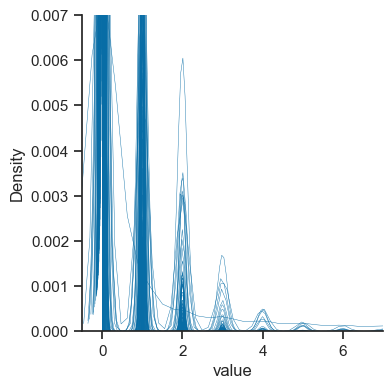

In [63]:
# show expression of 100 random genes (across all spots)
random_genes=random.sample(range(0, ad.X.shape[1]), 100)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
plt.show()

In [64]:
exp.iloc[0:5,0:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.999982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.999993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_12140/2170774648.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));


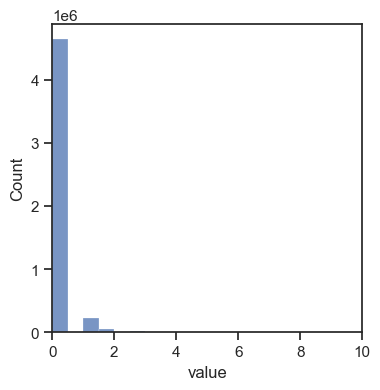

In [65]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));
pl.set(xlim=(0, 10));
plt.show()

Now normalize and log-transform

In [66]:
ad.layers["counts"] = ad.X.copy() # save unnormalized raw RNA counts - retrieve via ad.X = ad.layers["counts"]

In [67]:
sc.pp.normalize_total(ad, inplace=True) # Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization.

normalizing counts per cell
    finished (0:00:00)


In [68]:
sc.pp.log1p(ad) # X = log(X + 1)

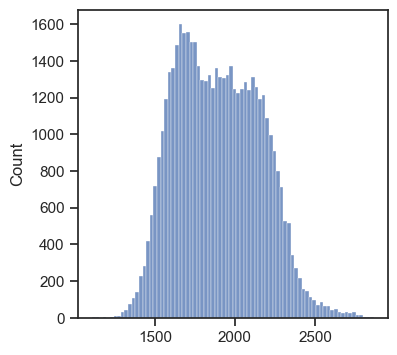

In [69]:
sns.histplot(ad.X.sum(1))
plt.show()

In [70]:
ad.layers["normalized"] = ad.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

In [71]:
ad

AnnData object with n_obs × n_vars = 49553 × 36138
    obs: 'cellId', 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'clusters', 'FBMC_score', 'SMC_score', 'FB_score', 'PC_score', 'sub_clusters', 'clusters2'
    uns: 'clusters2_colors', 'log1p'
    obsm: 'X_umap'
    layers: 'counts', 'log?', 'normalized'

In [72]:
ad.layers

Layers with keys: counts, log?, normalized

In [73]:
ad.obs["clusters"] = ad.obs["clusters2"]

In [74]:
winkler_pv = ad

### Merge

In [75]:
# free memory
del winkler_pv.layers["log?"]
del winkler_pv.layers["counts"]
del winkler_ec.layers["counts"]

In [76]:
del winkler_pv.uns
del winkler_ec.uns

In [77]:
del ad
del exp
del adata_sub
del random_genes

In [78]:
# merge winkler datasets
# ignore potential batch effects because dataset is pre-annotated
adata = anndata.concat([winkler_ec, winkler_pv], join="inner") 

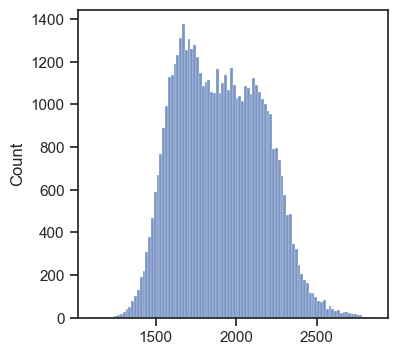

In [79]:
sns.histplot(adata.X.sum(1), bins = 100)
plt.show()

# Standard pipeline

Skip, because data is pre-analyzed.

# Vascular marker genes

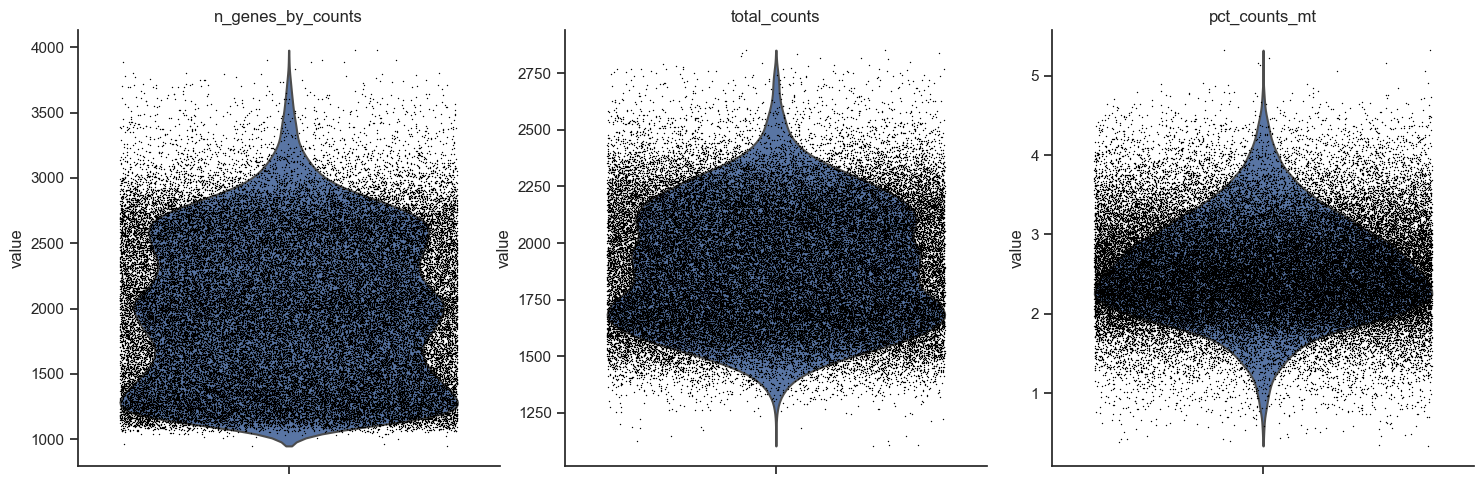

In [79]:
# Basic QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True)

In [ ]:
sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon')

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

Export DEG table

In [ ]:
import sys
sys.path.append(os.path.join(main_dir, "Git", "p06", "p06-visium", "visium-foxf2")
from p6_helper_functions import rank_genes_groups_df

In [108]:
# export DEG table
celltypes = adata.obs.clusters.unique().tolist()
merged_df = pd.DataFrame()
for group in celltypes:
    rank_df = rank_genes_groups_df(adata=adata, group=group, adj_pval_cutoff=None, log2fc_cutoff=None, sortby='zscore')
    merged_df = pd.concat([merged_df, rank_df])
    merged_df['reference'] = 'all other clusters'
merged_df.head(3)

divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10


,gene,log2FC,FC,pvals,pvals_adj,nlog10_pval_adj,zscore,group,reference
CLDN5,CLDN5,7.728694,212.113770,0.0,0.0,inf,115.524727,ECs,all other clusters
ST6GALNAC3,ST6GALNAC3,7.110999,138.236908,0.0,0.0,inf,112.986092,ECs,all other clusters
MECOM,MECOM,4.788053,27.627882,0.0,0.0,inf,110.516487,ECs,all other clusters


In [109]:
merged_df.group.unique().tolist()

['ECs', 'Fibromyocytes', 'SMCs', 'Fibroblasts', 'Pericytes']

In [110]:
# export as csv
merged_df.to_csv(os.path.join(main_dir, 'P6_Foxf2_per_celltype', 'DEA', date.today().strftime("%Y%m%d")+'_DE_genes_Winkler2022.csv'),sep=';')

# Focus on: Foxf2

In [80]:
gene="FOXF2"

## Plot

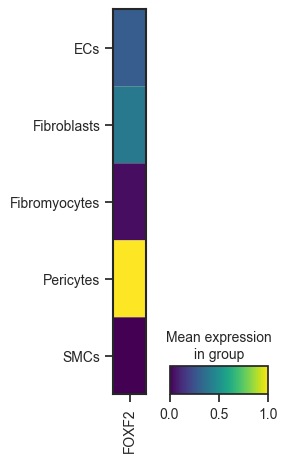

In [81]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

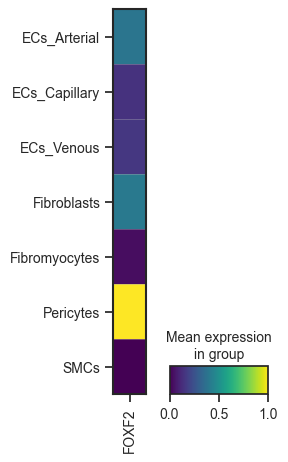

In [82]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


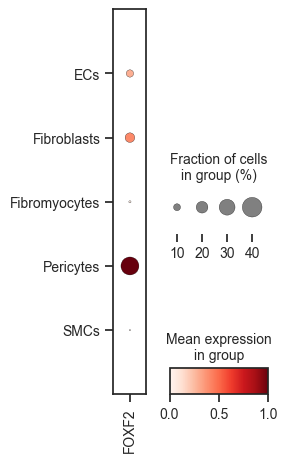

In [83]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


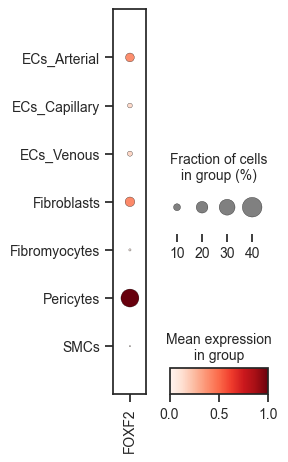

In [84]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

## Excl zonation

In [85]:
utils.summarize_gene_expression(adata = adata, gene = gene, groupby = "clusters", 
                                study_name = dataset_name, organism = organism,
                                export = True, output_dir = os.path.join(main_dir, "P06_Foxf2_per_celltype", "Foxf2_summarized")
                               )

Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Foxf2_summarized/20250306_FOXF2_Winkler2022_layernormalized.csv


,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
ECs,0.291276,0.107273,FOXF2,Winkler2022,Human,4950
Fibroblasts,0.403376,0.153991,FOXF2,Winkler2022,Human,3721
Fibromyocytes,0.033961,0.021365,FOXF2,Winkler2022,Human,4353
Pericytes,1.000000,0.355623,FOXF2,Winkler2022,Human,329
SMCs,0.000000,0.010474,FOXF2,Winkler2022,Human,41150


## Incl zonation

In [86]:
utils.summarize_gene_expression(adata = adata, gene = gene, groupby = "clusters2", 
                                study_name = dataset_name, organism = organism,
                                export = True, output_dir = os.path.join(main_dir, "P06_Foxf2_per_celltype", "Foxf2_summarized", "incl_zonation")
                               )

Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Foxf2_summarized/incl_zonation/20250306_FOXF2_Winkler2022_layernormalized.csv


,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
ECs_Arterial,0.388578,0.136868,FOXF2,Winkler2022,Human,2886
ECs_Capillary,0.143142,0.060606,FOXF2,Winkler2022,Human,165
ECs_Venous,0.156274,0.066351,FOXF2,Winkler2022,Human,1899
Fibroblasts,0.403376,0.153991,FOXF2,Winkler2022,Human,3721
Fibromyocytes,0.033961,0.021365,FOXF2,Winkler2022,Human,4353
Pericytes,1.000000,0.355623,FOXF2,Winkler2022,Human,329
SMCs,0.000000,0.010474,FOXF2,Winkler2022,Human,41150


# Focus on: Other genes

In [87]:
target_genes = ["Foxo1", "Tek", "Nos3", "Htra1", "Egfl8", "Flt1", "Kdr", "Ptprb", "Nrp1", "Nrp2", "Efnb2", "Itgb1", "Itga6", "Angpt2", "Cdh5", "Cldn5", "Ocln", "Ctnnb1"]

In [88]:
target_genes = [gene.upper() for gene in target_genes]
target_genes

['FOXO1',
 'TEK',
 'NOS3',
 'HTRA1',
 'EGFL8',
 'FLT1',
 'KDR',
 'PTPRB',
 'NRP1',
 'NRP2',
 'EFNB2',
 'ITGB1',
 'ITGA6',
 'ANGPT2',
 'CDH5',
 'CLDN5',
 'OCLN',
 'CTNNB1']

### Excl zonation

In [89]:
groupby = "clusters"

In [90]:
other_genes_results = {
    gene: utils.summarize_gene_expression(adata, gene, study_name = dataset_name, organism = organism, groupby = groupby, 
                                          output_dir=os.path.join(main_dir, "P06_Foxf2_per_celltype", "Other_genes_summarized"), export=True
                                         ) for gene in target_genes
}

Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_FOXO1_Winkler2022_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_TEK_Winkler2022_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_NOS3_Winkler2022_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_HTRA1_Winkler2022_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_EGFL8_Winkler2022_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_FLT1_Winkler2022_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_KDR_Winkler2022_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_PTPRB_Winkle

In [91]:
# some plots

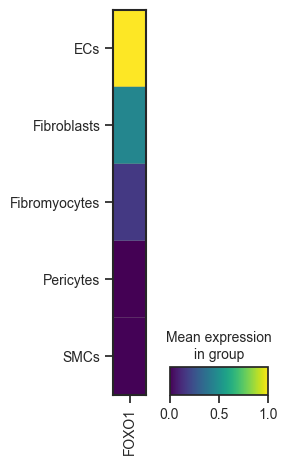

In [92]:
sc.pl.matrixplot(adata, [target_genes[0]], groupby=groupby, swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


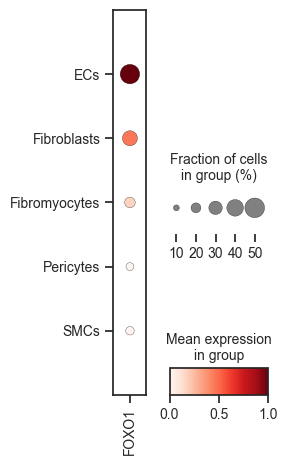

In [93]:
sc.pl.dotplot(adata, [target_genes[0]], groupby=groupby, swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

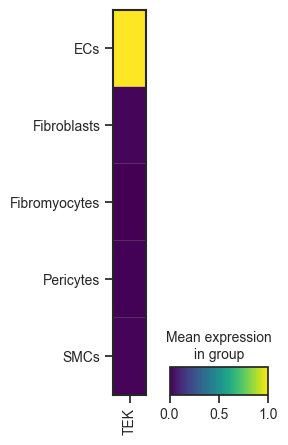

In [94]:
sc.pl.matrixplot(adata, [target_genes[1]], groupby=groupby, swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


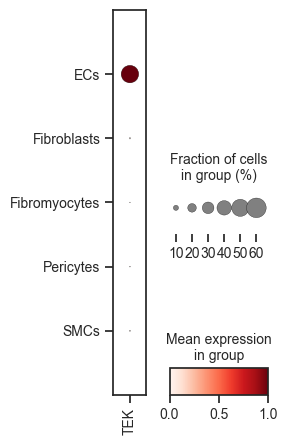

In [95]:
sc.pl.dotplot(adata, [target_genes[1]], groupby=groupby, swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Incl zonation

In [96]:
groupby = "clusters2"

In [97]:
other_genes_results = {
    gene: utils.summarize_gene_expression(adata, gene, study_name = dataset_name, organism = organism, groupby = groupby, 
                                          output_dir=os.path.join(main_dir, "P06_Foxf2_per_celltype", "Other_genes_summarized", "incl_zonation"), export=True
                                         ) for gene in target_genes
}

Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/incl_zonation/20250306_FOXO1_Winkler2022_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/incl_zonation/20250306_TEK_Winkler2022_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/incl_zonation/20250306_NOS3_Winkler2022_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/incl_zonation/20250306_HTRA1_Winkler2022_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/incl_zonation/20250306_EGFL8_Winkler2022_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/incl_zonation/20250306_FLT1_Winkler2022_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/incl_zonation/20250306_KDR_Winkler2022_layernormalized.csv
Expor

In [98]:
# some plots

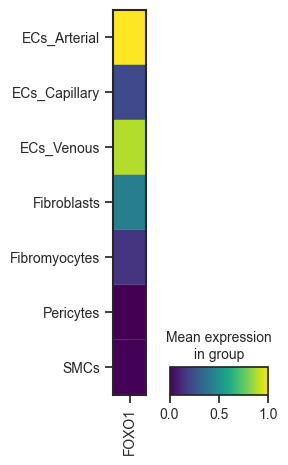

In [99]:
sc.pl.matrixplot(adata, [target_genes[0]], groupby=groupby, swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


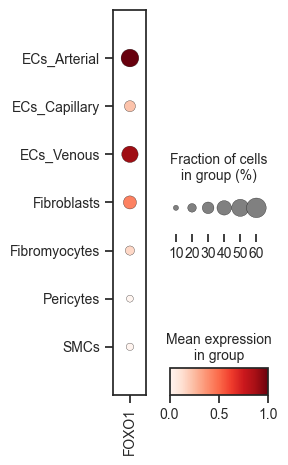

In [100]:
sc.pl.dotplot(adata, [target_genes[0]], groupby=groupby, swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

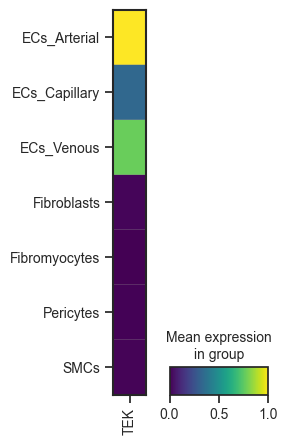

In [101]:
sc.pl.matrixplot(adata, [target_genes[1]], groupby=groupby, swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


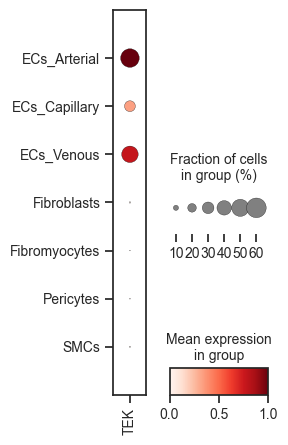

In [102]:
sc.pl.dotplot(adata, [target_genes[1]], groupby=groupby, swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

# Correlate gene expression (Foxf2 and Foxo1)

Using MAGIC denoising

In [81]:
import magic
import scprep

In [82]:
#sc.pp.scale(adata)

## ECs

In [83]:
gg = ["FOXF2","FOXO1","NOS3"]

In [84]:
adata_EC = adata[adata.obs.clusters == "ECs"]

In [85]:
adata_EC

View of AnnData object with n_obs × n_vars = 4950 × 29128
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'clusters2', 'clusters'
    obsm: 'X_umap'
    layers: 'normalized'

In [86]:
adata_EC.layers

LayersView with keys: normalized

In [87]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [88]:
cutoff_var = None

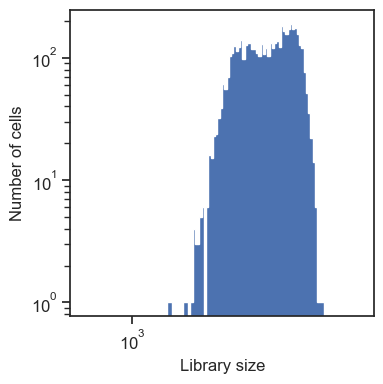

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [89]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [90]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [91]:
adata_EC.layers

LayersView with keys: normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [92]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [93]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=gg)

Calculating MAGIC...
  Running MAGIC on 4950 cells and 29128 genes.
  Calculating graph and diffusion operator...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculating PCA...
    Calculated PCA in 5.38 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.92 seconds.
    Calculating affinities...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\graphtools\graphs.py:290: RuntimeWarning: Detected zero distance between 516 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.99 seconds.
  Calculated graph and diffusion operator in 11.56 seconds.
  Calculating imputation...
Calculated MAGIC in 12.01 seconds.
CPU times: total: 26.4 s
Wall time: 12 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [94]:
np.corrcoef(emt_magic[:,['FOXF2','FOXO1']].X, rowvar = False)[0][1]

0.04880411284376483

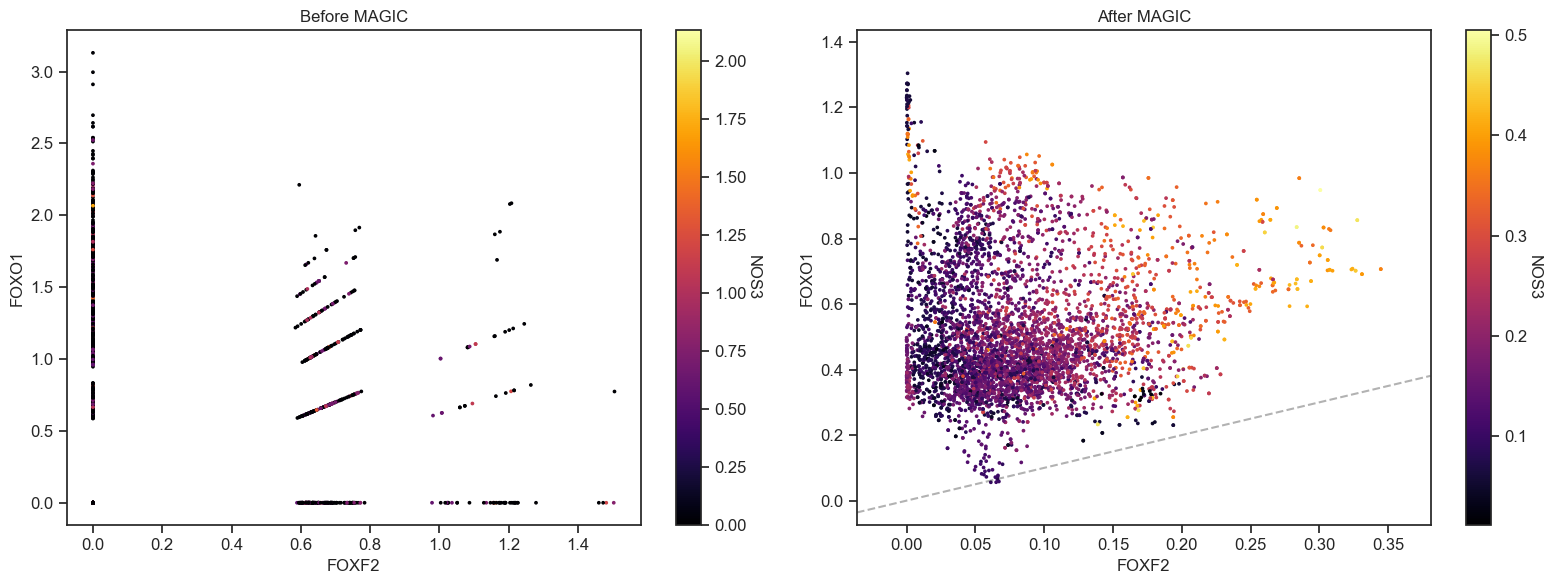

In [95]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'FOXF2'].X, y=adata_EC[:,'FOXO1'].X, c=adata_EC[:,'NOS3'].X, ax = ax1,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'FOXF2'].X, y=emt_magic[:,'FOXO1'].X, c=emt_magic[:,'NOS3'].X, ax=ax2,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## PCs

In [96]:
gg = ["FOXF2","FOXO1","NOS3"]

In [97]:
adata_EC = adata[adata.obs.clusters == "Pericytes"]

In [98]:
adata_EC

View of AnnData object with n_obs × n_vars = 329 × 29128
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'clusters2', 'clusters'
    obsm: 'X_umap'
    layers: 'normalized'

In [99]:
adata_EC.layers

LayersView with keys: normalized

In [100]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [101]:
cutoff_var = None

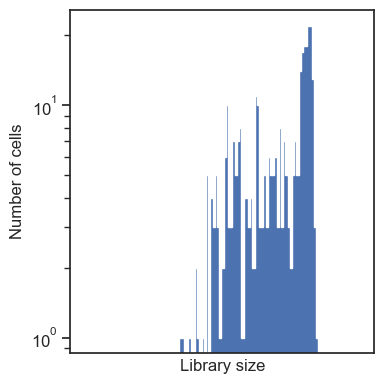

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [102]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [103]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [104]:
adata_EC.layers

LayersView with keys: normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [105]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [106]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=gg)

Calculating MAGIC...
  Running MAGIC on 329 cells and 29128 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 0.54 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.61 seconds.
  Calculating imputation...
Calculated MAGIC in 0.71 seconds.
CPU times: total: 1.92 s
Wall time: 714 ms


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\graphtools\graphs.py:283: RuntimeWarning: Detected zero distance between samples 33 and 44, 35 and 46, 36 and 47, 37 and 48, 38 and 49, 39 and 51. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [107]:
np.corrcoef(emt_magic[:,['FOXF2','FOXO1']].X, rowvar = False)[0][1]

0.2646949809161476

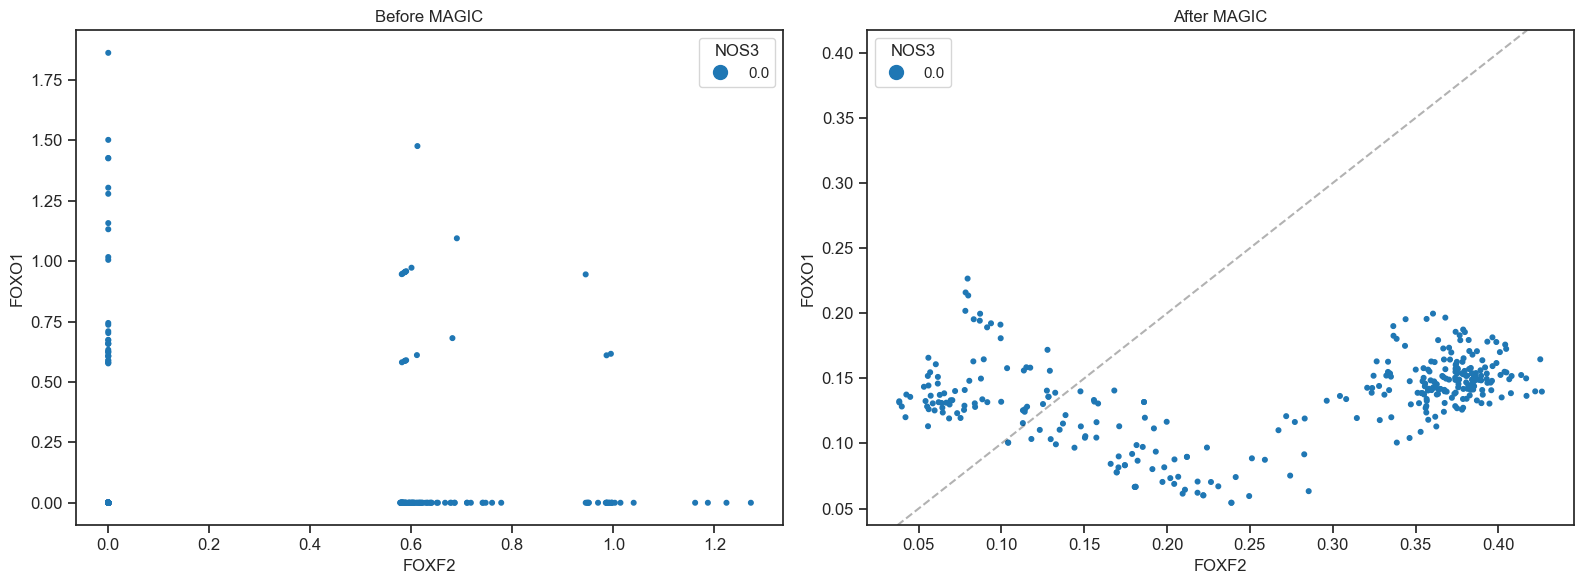

In [108]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'FOXF2'].X, y=adata_EC[:,'FOXO1'].X, c=adata_EC[:,'NOS3'].X, ax = ax1,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'FOXF2'].X, y=emt_magic[:,'FOXO1'].X, c=emt_magic[:,'NOS3'].X, ax=ax2,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='After MAGIC')
plt.axline((0.4,0.4), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## All cell types

In [109]:
gg = ["FOXF2","FOXO1","NOS3"]

In [110]:
adata_EC = adata

In [111]:
adata_EC

AnnData object with n_obs × n_vars = 54503 × 29128
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'clusters2', 'clusters'
    obsm: 'X_umap'
    layers: 'normalized'

In [112]:
adata_EC.layers

Layers with keys: normalized

In [113]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
cutoff_var = None

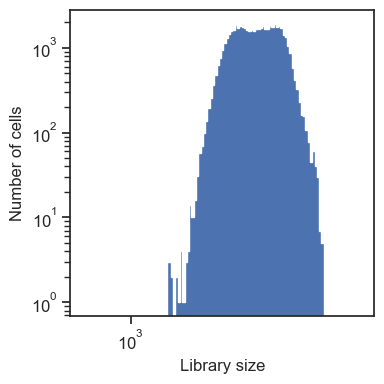

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [114]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [115]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [116]:
adata_EC.layers

Layers with keys: normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [117]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [118]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=gg)

Calculating MAGIC...
  Running MAGIC on 54503 cells and 29128 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 58.64 seconds.
    Calculating KNN search...
    Calculated KNN search in 484.23 seconds.
    Calculating affinities...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\graphtools\graphs.py:290: RuntimeWarning: Detected zero distance between 5917 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 436.43 seconds.
  Calculated graph and diffusion operator in 979.38 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 981.85 seconds.
CPU times: total: 18min 59s
Wall time: 16min 21s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [120]:
np.corrcoef(emt_magic[:,['FOXF2','FOXO1']].X, rowvar = False)[0][1]

0.47219464812294976

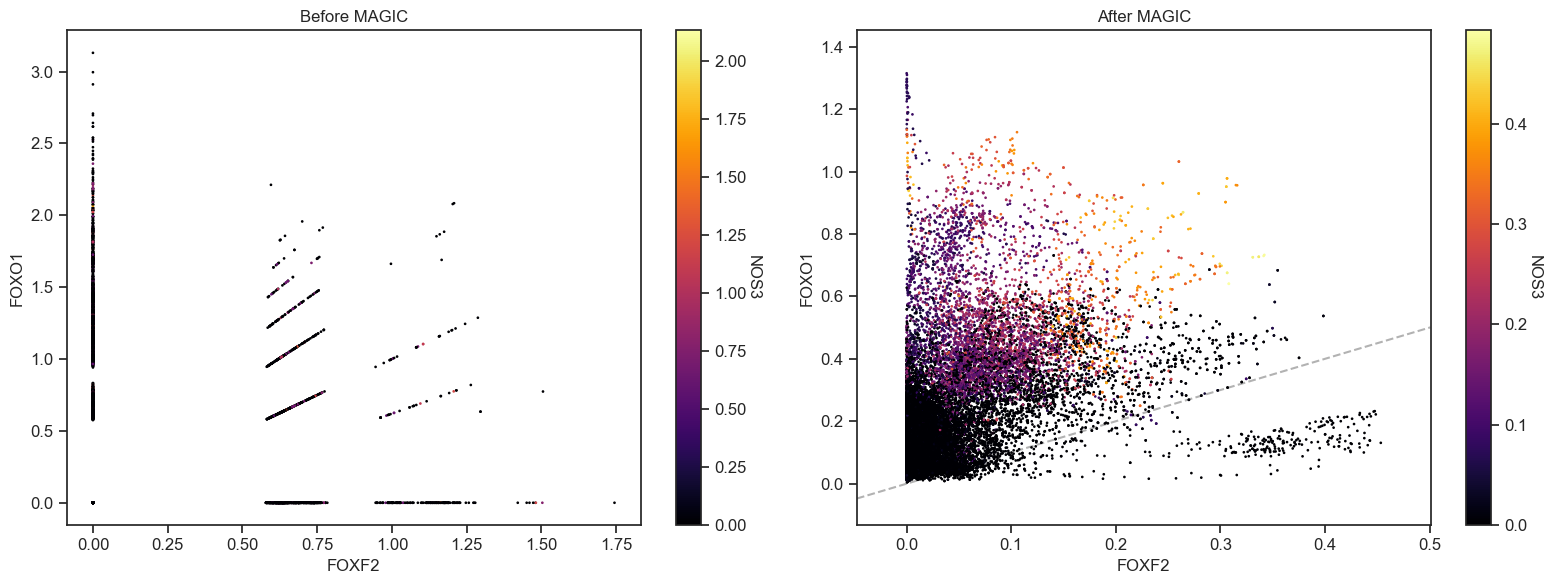

In [121]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'FOXF2'].X, y=adata_EC[:,'FOXO1'].X, c=adata_EC[:,'NOS3'].X, ax = ax1,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'FOXF2'].X, y=emt_magic[:,'FOXO1'].X, c=emt_magic[:,'NOS3'].X, ax=ax2,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## capECs

In [122]:
gg = ["FOXF2","FOXO1","NOS3"]

In [123]:
adata_EC = adata[adata.obs.clusters2 == "ECs_Capillary"]

In [124]:
adata_EC

View of AnnData object with n_obs × n_vars = 165 × 29128
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'clusters2', 'clusters'
    obsm: 'X_umap'
    layers: 'normalized'

In [125]:
adata_EC.layers

LayersView with keys: normalized

In [126]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [127]:
cutoff_var = None

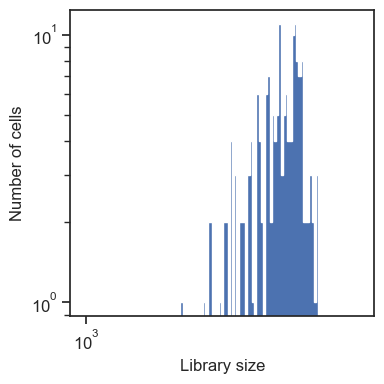

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [128]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [129]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [130]:
adata_EC.layers

LayersView with keys: normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [131]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [132]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=gg)

Calculating MAGIC...
  Running MAGIC on 165 cells and 29128 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 0.45 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.48 seconds.
  Calculating imputation...
Calculated MAGIC in 0.57 seconds.
CPU times: total: 1.52 s
Wall time: 575 ms


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\graphtools\graphs.py:290: RuntimeWarning: Detected zero distance between 17 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [133]:
np.corrcoef(emt_magic[:,['FOXF2','FOXO1']].X, rowvar = False)[0][1]

-0.028910513191941593

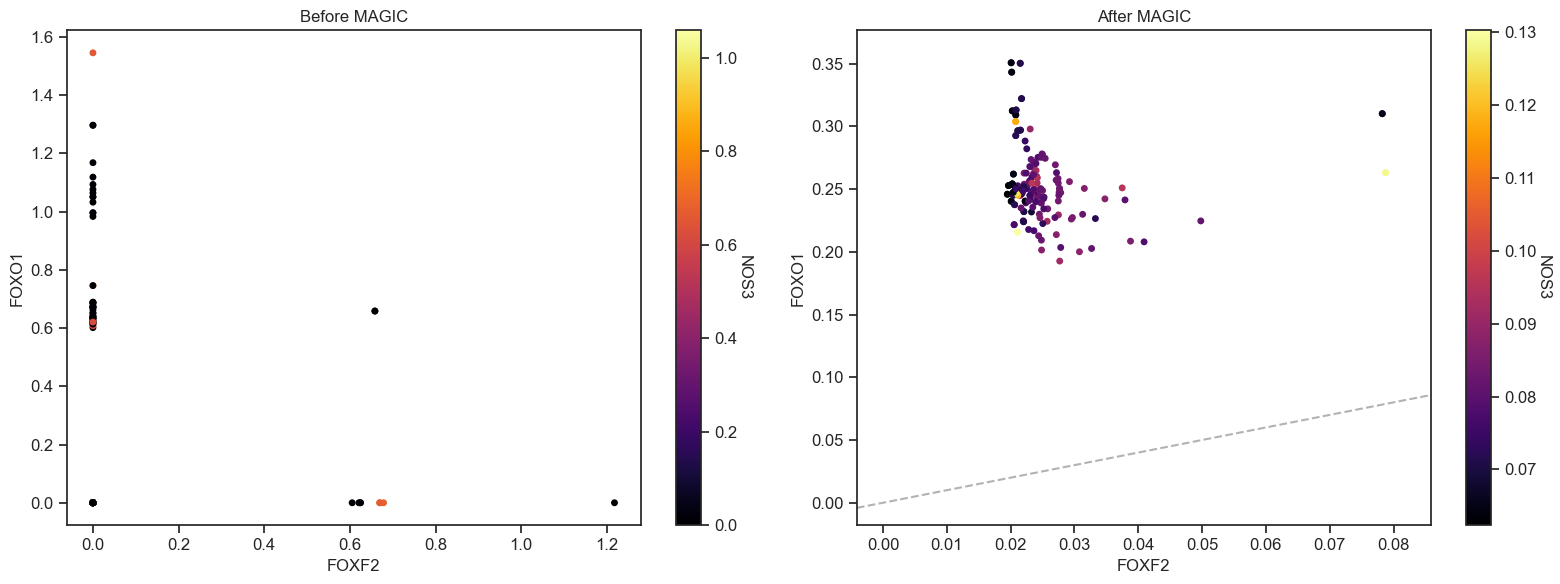

In [134]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'FOXF2'].X, y=adata_EC[:,'FOXO1'].X, c=adata_EC[:,'NOS3'].X, ax = ax1,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'FOXF2'].X, y=emt_magic[:,'FOXO1'].X, c=emt_magic[:,'NOS3'].X, ax=ax2,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## aECs

In [135]:
gg = ["FOXF2","FOXO1","NOS3"]

In [136]:
adata_EC = adata[adata.obs.clusters2 == "ECs_Arterial"]

In [137]:
adata_EC

View of AnnData object with n_obs × n_vars = 2886 × 29128
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'clusters2', 'clusters'
    obsm: 'X_umap'
    layers: 'normalized'

In [138]:
adata_EC.layers

LayersView with keys: normalized

In [139]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [140]:
cutoff_var = None

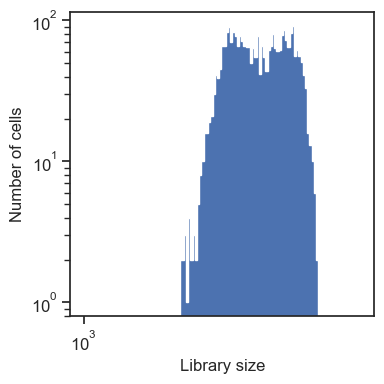

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [141]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [142]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [143]:
adata_EC.layers

LayersView with keys: normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [144]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [145]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=gg)

Calculating MAGIC...
  Running MAGIC on 2886 cells and 29128 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 3.20 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.93 seconds.
    Calculating affinities...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\graphtools\graphs.py:290: RuntimeWarning: Detected zero distance between 156 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 0.95 seconds.
  Calculated graph and diffusion operator in 5.24 seconds.
  Calculating imputation...
Calculated MAGIC in 5.51 seconds.
CPU times: total: 14 s
Wall time: 5.51 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [146]:
np.corrcoef(emt_magic[:,['FOXF2','FOXO1']].X, rowvar = False)[0][1]

0.15339435830835435

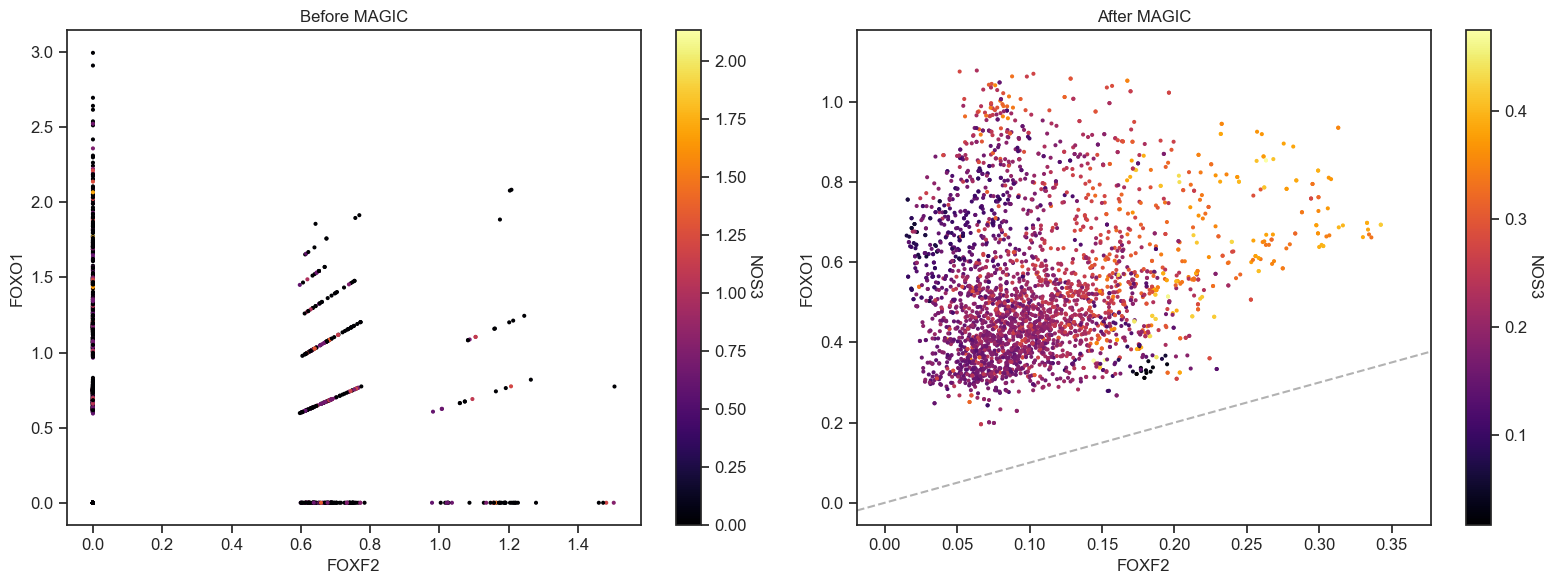

In [147]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'FOXF2'].X, y=adata_EC[:,'FOXO1'].X, c=adata_EC[:,'NOS3'].X, ax = ax1,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'FOXF2'].X, y=emt_magic[:,'FOXO1'].X, c=emt_magic[:,'NOS3'].X, ax=ax2,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## vECs

In [148]:
gg = ["FOXF2","FOXO1","NOS3"]

In [149]:
adata_EC = adata[adata.obs.clusters2 == "ECs_Venous"]

In [150]:
adata_EC

View of AnnData object with n_obs × n_vars = 1899 × 29128
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'clusters2', 'clusters'
    obsm: 'X_umap'
    layers: 'normalized'

In [151]:
adata_EC.layers

LayersView with keys: normalized

In [152]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [153]:
cutoff_var = None

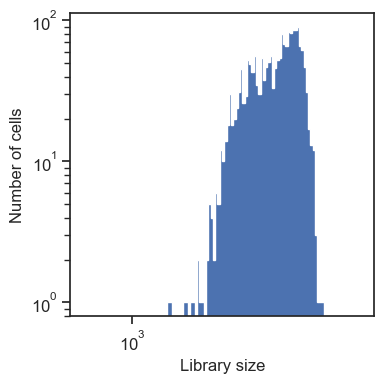

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [154]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [155]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [156]:
adata_EC.layers

LayersView with keys: normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [157]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [158]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=gg)

Calculating MAGIC...
  Running MAGIC on 1899 cells and 29128 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 2.22 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.39 seconds.
    Calculating affinities...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\graphtools\graphs.py:290: RuntimeWarning: Detected zero distance between 12 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 3.09 seconds.
  Calculating imputation...
Calculated MAGIC in 3.31 seconds.
CPU times: total: 9.59 s
Wall time: 3.31 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [159]:
np.corrcoef(emt_magic[:,['FOXF2','FOXO1']].X, rowvar = False)[0][1]

-0.38683976081188426

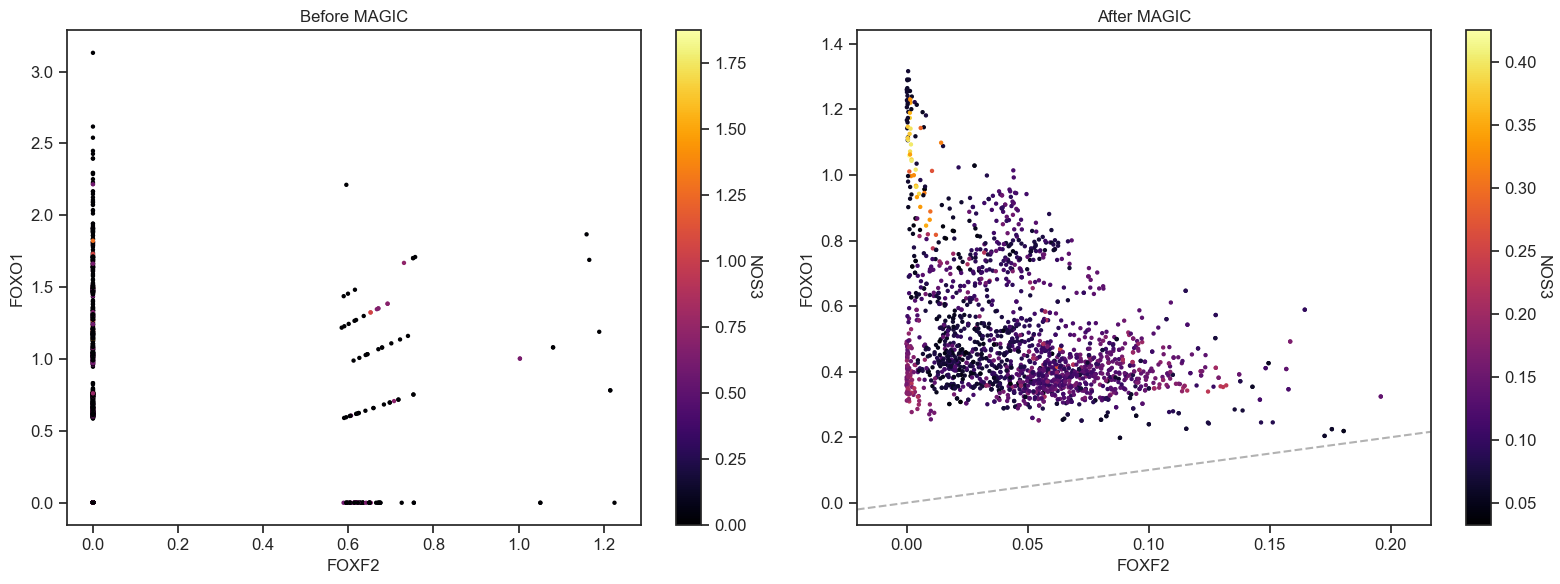

In [160]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'FOXF2'].X, y=adata_EC[:,'FOXO1'].X, c=adata_EC[:,'NOS3'].X, ax = ax1,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'FOXF2'].X, y=emt_magic[:,'FOXO1'].X, c=emt_magic[:,'NOS3'].X, ax=ax2,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# Session Info

In [161]:
sc.logging.print_versions()

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                 10.0.0
anyio               NA
asttokens           NA
attr                22.1.0
babel               2.11.0
backcall            0.2.0
brotli              NA
certifi             2023.07.22
cffi                1.15.1
charset_normalizer  2.0.4
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
deprecated          1.2.14
entrypoints         0.4
executing           0.8.3
fastjsonschema      NA
future              0.18.3
graphtools          1.5.3
h5py                3.9.0
idna                3.4
igraph              0.10.4
ipykernel           6.25.0
ipython_genutils    0.2.0
ipywidgets          8.0.4
jedi                0.18.1
jinja2              3.0.3
joblib              1.3.2
json5               NA
jsonschema          4.17.3
jupyter_server      1.23.4
jupyterlab_server   2